In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mathis as mt
import math
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.dummy import DummyRegressor

In [2]:
train = pd.read_csv("datasets/modified_train.csv")
test = pd.read_csv("datasets/modified_test.csv")

train = train.drop(columns = ['Unnamed: 0', 'training'])
test = test.drop(columns = ['Unnamed: 0', 'training'])

house = train.append(test)

In [3]:
def quick_lr(columns):
    X = train[columns]
    y = train['sale_price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    return r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred, squared = False)

# Modeling

***Test Models***

In [4]:
x_list = house.columns.tolist()
x_list.remove('sale_price')
X = train[x_list]
y = train['sale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [5]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)
r_alphas = np.logspace(0,100,1000)
lasso_cv = LassoCV(alphas=r_alphas, random_state=42, cv=5, max_iter = 10000)
lasso_cv.fit(Z_train,y_train);
lasso_pred = lasso_cv.predict(Z_test)

In [6]:
sc = StandardScaler()
Z_train2 = sc.fit_transform(X_train)
Z_test2 = sc.transform(X_test)
r_alphas = np.logspace(0,100,1000)
ridge_cv = RidgeCV(alphas=r_alphas,scoring="neg_mean_squared_error", cv=5)
ridge_cv.fit(Z_train2,y_train);
ridge_pred = ridge_cv.predict(Z_test2)

In [7]:
best_corrs = mt.corrs_selection(train, 'sale_price')
best_corrs

,overall_qual,year_built,year_remod/add,mas_vnr_area,exter_qual,bsmt_qual,total_bsmt_sf,1st_flr_sf,gr_liv_area,full_bath,kitchen_qual,tot_rms_abv_grd,fireplace_qu,garage_yr_blt,garage_finish,garage_cars,garage_area,foundation_PConc
0,0.810548,0.585223,0.559321,0.503621,0.714711,0.619759,0.655701,0.643099,0.713283,0.542345,0.698426,0.503016,0.537636,0.568093,0.565849,0.653993,0.654364,0.542314


In [8]:
counts = mt.colinearity_count(train, best_corrs.columns.tolist())

In [9]:
#credit to: Dan Andrews
def adjusted_r2(r2, X, y):
    return 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)

In [10]:
dum = DummyRegressor(strategy = 'mean')

In [11]:
dum.fit(X_train, y_train)
dum_pred = dum.predict(X_test)
r2 = dum.score(X_train,y_train)
print(f'Adjusted R2: {adjusted_r2(r2, X_train, y_train)}, RMSE: {mean_squared_error(y_test, dum_pred, squared = False)}')

Adjusted R2: -0.20500403551251, RMSE: 80723.5596924164


- Dummy model for reference. Predicting the mean gives a terrible R2 and a baseline for our RMSE.

In [12]:
r2 = lasso_cv.score(Z_train,y_train)
print(f'Adjusted R2: {adjusted_r2(r2, Z_train, y_train)}, RMSE: {mean_squared_error(y_test, lasso_pred, squared = False)}')

Adjusted R2: 0.9182566156536868, RMSE: 24577.652585376145


- LASSO presents a marginally worse R2 than Ridge and a slightly better RMSE. This RMSE is likely due to the large number of binary categorical columns in the dataset, which LASSO can elect to ignore and Ridge cannot.

In [13]:
r2 = ridge_cv.score(Z_train2,y_train)
print(f'Adjusted R2: {adjusted_r2(r2, Z_train2, y_train)}, RMSE: {mean_squared_error(y_test, ridge_pred, squared = False)}')

Adjusted R2: 0.9212927961013377, RMSE: 25038.74948855554


In [14]:
r2, rmse = quick_lr(best_corrs.columns.tolist())
print(f'Adjusted R2: {adjusted_r2(r2, X_train, y_train)}, RMSE: {rmse}')

Adjusted R2: 0.8327068530074031, RMSE: 29926.7794449836


- An MLR using only the columns that are most strongly correlated to sale price shows a fair decrease in both R2 and RMSE compared to LASSO and Ridge. The clear reason for this is that more than half of the variables correlated with price are also colinear, violating LINE assumptions.

In [15]:
r2, rmse = quick_lr([key for key, val in counts.items() if val < 4])
print(f'Adjusted R2: {adjusted_r2(r2, X_train, y_train)}, RMSE: {rmse}')

Adjusted R2: 0.6323485412857869, RMSE: 44364.8537576636


- Finally, an MLR selecting for the columns strongly correlated to sale price while also being the least correlated with each other provides an even worse R2 and and RMSE of roughly 2/3 a baseline model. This is including adjusted R2 on the highly colinear model, which should reduce R2 for having more variables than the low colinearity model. 

***Kaggle submission***

In [16]:
sc = StandardScaler()
Z_train = sc.fit_transform(train[x_list])
Z_test = sc.transform(test[x_list])
r_alphas = np.logspace(0,100,1000)
lasso_cv = LassoCV(alphas=r_alphas, random_state=42, cv=5, max_iter = 10000)
lasso_cv.fit(Z_train,y)
test_ids = test['id']
test_preds = lasso_cv.predict(Z_test)

In [17]:
#credit to Gwen Rathgeber
kaggle_submission = {
    'Id': test_ids,
    'SalePrice': test_preds
}

kaggle_submission = pd.DataFrame(kaggle_submission)

In [18]:
kaggle_submission.head(5)

,Id,SalePrice
0,2658,135547.345824
1,2718,154943.062667
2,2414,230483.684384
3,1989,112894.736296
4,625,176565.127608


***Kaggle Results***

Submissions:
   - LASSO no buckets no outliers: 26734.00198
   - LASSO no buckets: 29754.67899
   - LASSO with outliers: 32135.00957
   - LASSO without outliers: 32414.92745 (30734.27885 with better buckets)
   - Linear using LASSO as feature selection: 28405.96638
   - Ridge no buckets: 32813.94436
   - Ridge with outliers: 32593.92522
   - Ridge without outliers: 33994.54079
   - Just best corrs: 34950.18614
   - Min colinearity: 51789.76432
   - Dummy: 80723.5596924164

In [21]:
rmses = {'RMSE': {'Baseline': 80723.5596924164, 'Linear': 51789.76432, 'Ridge': 32593.92522, 'Linear+LASSO':28405.96638, 'LASSO':26734.00198}}

In [22]:
rmse_chart = pd.DataFrame(rmses)

In [31]:
rmse_chart = rmse_chart.reset_index()

In [37]:
rmse_chart.sort_values(by = 'RMSE', ascending = False, inplace = True)

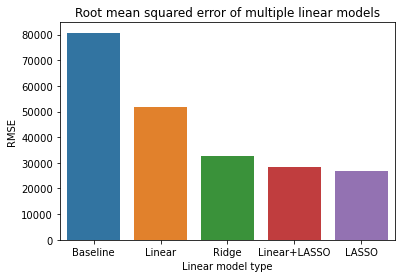

In [40]:
sns.barplot(data = rmse_chart, y = 'RMSE', x= 'index')
plt.title('Root mean squared error of multiple linear models')
plt.xlabel('Linear model type')
plt.show()

- For analysis, we will use LASSO to select best features (as it has the best error), followed by a linear model on those features (for predictive power).

***To step 3***